<a href="https://colab.research.google.com/github/Camillabgarcia/Apache_Spark_com_Python/blob/main/Spark_processamento_de_linguagem_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.0 Introdução
### **1.1 Sessão e leitura dos dados**

Instalando o PySpark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=8c87ee85c54165435941fb3ee4a48ecfdc55c46ffdf8a55cbf1c1e2e6e7be204
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Iniciando uma sessão

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [4]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/drive/MyDrive/Spark_processamento_de_linguagem_natural/imdb-reviews-pt-br.csv.crdownload",
                       escape="\"",
                       header=True,
                       inferSchema=True)

### **1.2 Explorando os dados**

Explorando os dados bucando entender:
- O tamanho dos dados (quantidade de linhas e colunas).
- Os campos e tipo.
- O conteúdo em cada campo.
- A proporção das categorias.

O tamanho dos dados:



In [5]:
print(f'Número de linhas: {dados.count()}', f'Número de colunas: {len(dados.columns)}')

Número de linhas: 48751 Número de colunas: 4


Campos e tipo:

In [6]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



Conteúdo da base de dados:

In [7]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



Apresentando alguns comentários ditos como negativo ou positivo:

In [8]:
print('Comentário Negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)
print('Comentário Positivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

Comentário Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                      

Contabilizando os tipodes de comentários positivos/negativos:

In [9]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|23985|
|      neg|24765|
|     NULL|    1|
+---------+-----+



**2.0 Limpeza e Processamento**

2.1 Processo e bibliotecas

Iniciaremos nosso projeto criando uma nuvem de palavras que nos ajudará a perceber quais termos mais se repetem e quais podem ser removidos no processamento de dados. Importando as bibliotecas necessárias:

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Coletando uma amostra dos nossos depoimentos para otimizar o processamento do Spark:

In [13]:
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

Construindo o word cloud:

In [22]:
wordcloud = WordCloud(background_color= 'white',
                      width = 1000,
                      height= 600,
                      collocations=False,
                      prefer_horizontal=1).generate(str(tudo))

Visualizando o WordCloud:

 Identificamos a presença de várias preposições como "não", "que" e "para", além de outros termos que não agregam muito sentido à nossa análise. Esta observação nos leva à conclusão que nosso conjunto de dados precisa passar por alguns processos de remoção de palavras.

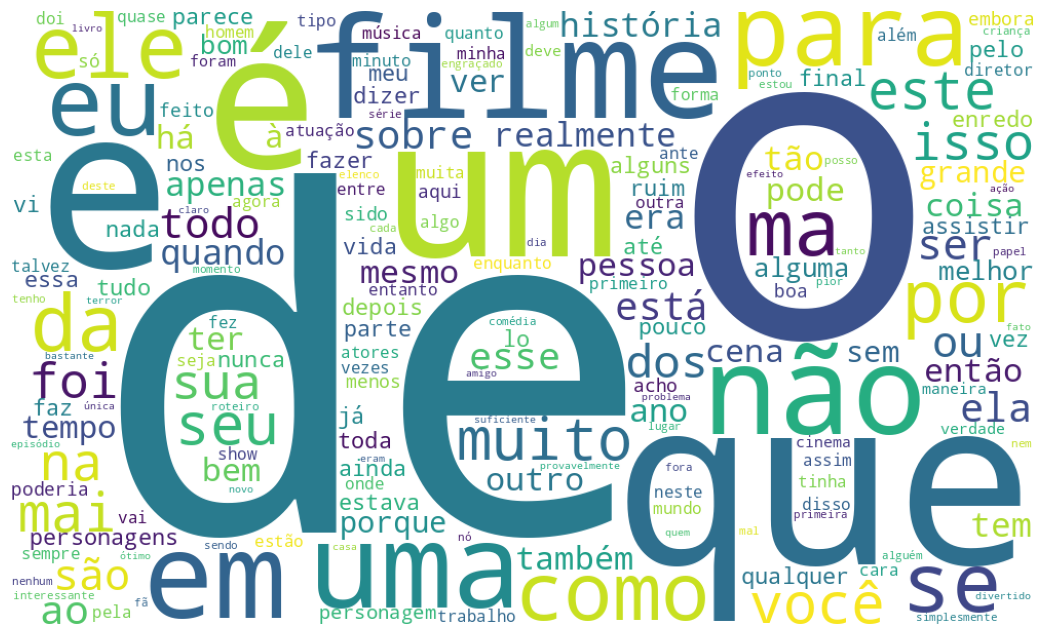

In [23]:
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

2.1 Limpeza: caractere especiais:

Caracteres de pontuação comuns:

In [24]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Exemplo de dataframe para a limpeza:

In [25]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

Importando a função Regex:

In [27]:
import pyspark.sql.functions as f

Iniciando o código de limpeza:

In [30]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

Visualizando o dataframe limpo:

In [31]:
amostra.show(truncate=False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



Retirando os espaços em branco no exemplo:

In [33]:
amostra = amostra.withColumn('texto_limpo', f.trim(amostra.texto_regex))
amostra.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

Retirando os caracteres especiais dos dados reais:

In [34]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Retirando os espaços em branco do começo e do final de cada frase:

In [36]:
dados = dados.withColumn('texto_limpo', f.trim(dados.texto_regex))
dados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



2.3 Tokenização: divisão em tokens

Importando a função Tokenizer e criando um objeto onde constam os comentários onde aplicamos, anteriormente, Regex e Trim na coluna de entrada e constarãos os tokens criados a partir dos depoimentos na coluna de saída:

In [37]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")